# NEURAL MACHINE TRANSLATION
## Dịch các câu từ tiếng Anh sang tiếng Việt

Dịch máy (Neural Machine Translation - NMT) liên quan đến việc dịch các cụm từ và câu qua các ngôn ngữ khác nhau bằng việc sử dụng các kỹ thuật học sâu, đặc biệt là RNN (Recurrent Neural Nets). Hầu hết các hệ thống này là các hệ thống phức tạp bao gồm nhiều thuật toán. Tuy nhiên, hiện tại, NMT sử dụng các mô hình sequence-to-sequence (Seq2Seq) RNN. Những mô hình này có thể xử lý ở cấp độ ký tự hoặc cấp độ từ, nhưng những mô hình cấp từ vẫn là phổ biến.

Lưu ý: Nên thay đổi runtime sang GPU runtime để quá trình huấn luyện có thể nhanh hơn.

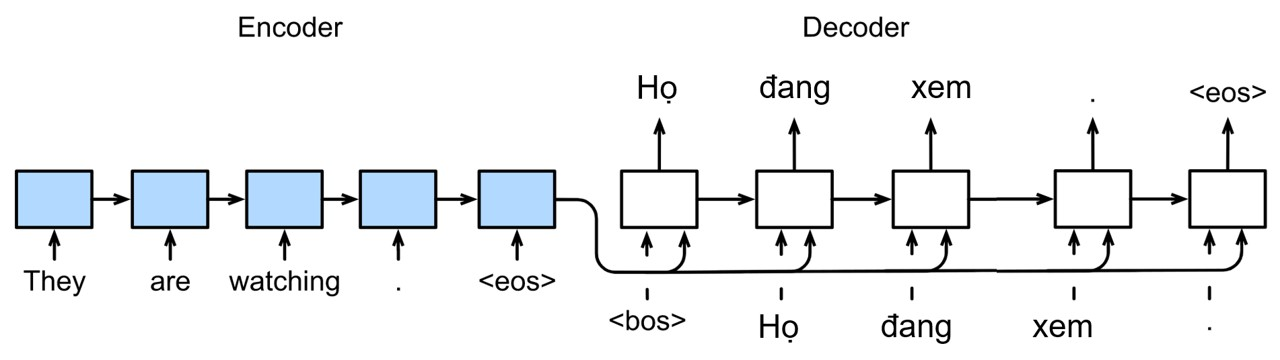

## Chúng ta sẽ làm gì trong bài tập này?
Chúng ta sẽ tạo ra một mô hình LSTM encoder-decoder sử dụng [Keras Functional API](https://www.tensorflow.org/alpha/guide/keras/functional ( với [TensorFlow](https://www.tensorflow.org/) ). Sau đó, chúng ta thực hành chuyển đổi các câu tiếng Anh sang Tiếng Việt.


## Chuẩn bị dữ liệu

### 1) Khai báo các thư viện

Chúng ta sẽ khai báo TensorFlow và Keras. Từ Keras, chúng ta sẽ sử dụng các module khác để giúp xây dựng các lớp NN, tiền xử lý dữ liệu và xây dựng các mô hình LSTM

In [1]:
# import các thư viện cần thiết
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd

def fix_random_seed():
    np.random.seed(1)
    tf.random.set_seed(1)

### 2) Đọc dữ liệu


Dữ liệu có hơn 9K cặp cụm từ English-Vietnamese. Bộ dữ liệu này có thể tải tại http://www.manythings.org/anki/. Hơn thế nữa, tại đây có hơn 50 bộ câu song ngữ. Chúng ta sẽ tải bộ dữ liệu cụm từ English-Vietnamese, giải nén và đọc bằng [Pandas](https://pandas.pydata.org/).

**Server đã có sẵn dữ liệu này cho các bạn sử dụng, các bạn có thể sử dụng các lệnh dưới đây để tải và sử dụng dữ liệu trên các nền tảng khác.**

In [2]:
# !wget http://www.manythings.org/anki/vie-eng.zip -O vie-eng.zip
# !unzip vie-eng.zip

Sử dụng pandas để đọc dữ liệu và thêm tên cho các cột.

In [3]:
lines = None

# TODO: đọc dữ liệu bằng `padas.read_table`, 
# gắn label cho 2 cột đầu là `eng` và `vie`,
# loại bỏ cột cuối cùng

# BEGIN SOLUTION
lines = pd.read_table('/data/cs2230/vie.txt' , names=['eng' , 'vie' , 'c' ] )
lines = lines.drop( 'c' , 1 )
# END SOLUTION

lines.head()

/tmp/ipykernel_5497/4127352055.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lines = lines.drop( 'c' , 1 )


,eng,vie
0,Run!,Chạy!
1,Run!,Chạy đi!
2,Help!,Giúp tôi với!
3,Help!,Cứu tôi!
4,Jump!,Nhảy đi!


In [4]:
# Kiểm tra với bộ test
assert str(type(lines)) =="<class 'pandas.core.frame.DataFrame'>" 
assert list(lines.columns) == ['eng' , 'vie']
assert lines.shape == (9144, 2) 
assert lines.iloc[10]['eng']=='Hurry!'
print('Bạn đã qua bài test')

Bạn đã qua bài test


In [5]:
# Kiểm tra với bộ test ẩn
# BEGIN HIDDEN TESTS
assert str(type(lines)) =="<class 'pandas.core.frame.DataFrame'>" 
assert list(lines.columns) == ['eng' , 'vie']
assert lines.shape == (9144, 2) 
assert lines.iloc[10]['eng']=='Hurry!'
index = [150, 200, 500]
gt = ["I don't know.", 'Trust no one.', 'This car is his.']
for i, gt in zip(index, gt):
    assert lines.iloc[i]['eng']==gt
# END HIDDEN TESTS

### 3) Chuẩn bị dữ liệu đầu vào cho Encoder (`encoder_input_data`)
Mô hình Encoder sẽ được cung cấp dữ liệu đầu vào là các câu tiếng Anh đã được tiền xử lý. 
Bước tiền xử lý được thực hiện như sau:

Token hóa các câu tiếng Anh từ `eng_lines`.
Xác định độ dài tối đa của câu tiếng Anh là `max_input_length`.
Thêm vào `tokenized_eng_lines` để đạt đến `max_input_length`.
Xác định kích thước từ vựng (`num_eng_tokens`) cho các từ tiếng Anh.

In [6]:
eng_lines = list()
for line in lines.eng:
    eng_lines.append( line ) 

tokenizer = None
tokenized_eng_lines = None
max_input_length =  None

# TODO: Sử dụng `preprocessing.text.Tokenizer` để biến đổi các câu thành các 
# tokens và lưu vào biến `tokenized_eng_lines`. Biến `max_input_length` lưu trữ
# độ dài tối đa của các tokens.
# Gợi ý: dùng 2 hàm là `fit_on_texts` và `texts_to_sequences`

# BEGIN SOLUTION
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( eng_lines ) 
tokenized_eng_lines = tokenizer.texts_to_sequences( eng_lines ) 
max_input_length = np.array( [len( token_seq ) for token_seq in tokenized_eng_lines] ).max()
# END SOLUTION

# sử dụng pad_sequences để cố định kích thước input của encoder
padded_eng_lines = preprocessing.sequence.pad_sequences( tokenized_eng_lines, maxlen=max_input_length , padding='post' )
encoder_input_data = np.array( padded_eng_lines )

eng_word_dict = tokenizer.word_index
num_eng_tokens = len( eng_word_dict )+1

print( 'Độ dài lớn nhất của English là {}'.format( max_input_length ))
print( 'Kích thước dữ liệu của Encoder  -> {}'.format( encoder_input_data.shape ))
print( 'Số lượng English tokens = {}'.format( num_eng_tokens))


Độ dài lớn nhất của English là 32
Kích thước dữ liệu của Encoder  -> (9144, 32)
Số lượng English tokens = 4054


### 4) Chuẩn bị dữ liệu đầu vào cho Decoder ( `decoder_input_data` )
Mô hình decoder sẽ được cung cấp dữ liệu tiếng Việt đã được tiền xử lý. Các bước tiền xử lý giống như trên. Bước này được thực hiện trước các bước khác.

Thêm nhãn `<START>` vào vị trí đầu tiên trong mỗi câu tiếng Việt.
Thêm nhãn `<END>` vào vị trí cuối cùng trong mỗi câu tiếng Việt.



In [7]:

vie_lines = list()
# TODO: Khác với trên chúng ta phải thêm '<START> ' và ' <END>' vào 
# các câu tiếng Việt để tạo thành các dữ liệu đầu vào cho decoder

# BEGIN SOLUTION
for line in lines.vie:
    vie_lines.append( '<START> ' + line + ' <END>' )  
# END SOLUTION


tokenizer = None
tokenized_vie_lines = None
max_output_length = None

# TODO: Tương tự như trên, chúng ta cũng sử dụng `preprocessing.text.Tokenizer` 
# để biến đổi các câu thành các tokens và lưu vào biến `tokenized_vie_lines`. 
# Biến `max_output_length` lưu trữ độ dài tối đa của các tokens.
# Gợi ý: dùng 2 hàm là `fit_on_texts` và `texts_to_sequences`

# BEGIN SOLUTION
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( vie_lines ) 
tokenized_vie_lines = tokenizer.texts_to_sequences( vie_lines ) 
max_output_length = np.array( [len( token_seq ) for token_seq in tokenized_vie_lines] ).max()
# END SOLUTION

# sử dụng pad_sequences để cố định kích thước output của decoder
padded_vie_lines = preprocessing.sequence.pad_sequences( tokenized_vie_lines , maxlen=max_output_length, padding='post' )
decoder_input_data = np.array( padded_vie_lines )
vie_word_dict = tokenizer.word_index
num_vie_tokens = len( vie_word_dict )+1


print( 'Độ dài lớn nhất của tiếng việt là {}'.format( max_output_length ))
print( 'kích thước dữ liệu đầu vào của Decoder -> {}'.format( decoder_input_data.shape ))
print( 'Số lượng Vietnamese tokens = {}'.format( num_vie_tokens))

Độ dài lớn nhất của tiếng việt là 43
kích thước dữ liệu đầu vào của Decoder -> (9144, 43)
Số lượng Vietnamese tokens = 2478


In [8]:
# Kiểm tra với bộ test
assert num_eng_tokens == 4054
assert num_vie_tokens == 2478
assert decoder_input_data.shape == (9144, 43)
assert encoder_input_data.shape == (9144, 32)
assert tokenized_vie_lines[50:55] == [[1, 378, 2],
 [1, 11, 9, 14, 21, 3, 2],
 [1, 11, 9, 14, 21, 22, 2],
 [1, 1212, 57, 2],
 [1, 1212, 57, 18, 2]]
assert tokenized_eng_lines[50:55] == [[52, 294], [52, 1462], 
                                      [52, 1462], [180, 137], [180, 137]]
print('Bạn đã qua bài test')                                      

Bạn đã qua bài test


In [9]:
# Kiểm tra với bộ test ẩn
# BEGIN HIDDEN TESTS
assert num_eng_tokens == 4054
assert num_vie_tokens == 2478
assert decoder_input_data.shape == (9144, 43)
assert encoder_input_data.shape == (9144, 32)

assert tokenized_vie_lines[50:55] == [[1, 378, 2],
 [1, 11, 9, 14, 21, 3, 2],
 [1, 11, 9, 14, 21, 22, 2],
 [1, 1212, 57, 2],
 [1, 1212, 57, 18, 2]]
assert tokenized_eng_lines[50:55] == [[52, 294], [52, 1462], 
                                      [52, 1462], [180, 137], [180, 137]]
assert tokenized_vie_lines[10:20] == [[1, 271, 130, 2],
 [1, 271, 130, 39, 2],
 [1, 3, 16, 245, 2],
 [1, 3, 16, 245, 143, 69, 2],
 [1, 1840, 2],
 [1, 55, 18, 2],
 [1, 55, 42, 18, 2],
 [1, 157, 65, 2],
 [1, 113, 30, 2],
 [1, 96, 69, 2]]

assert tokenized_eng_lines[80:90] == [[138, 13, 163],
 [57, 948],
 [50, 7, 59],
 [50, 7, 59],
 [50, 7, 59],
 [4, 1817],
 [4, 1817],
 [432, 48],
 [26, 2500],
 [17, 866]]
# END HIDDEN TESTS

### 5) Chuẩn bị nhãn cho decoder ( decoder_target_data )

Chúng ta sẽ lấy một bản sao của `tokenized_vie_lines` và sửa đổi nó như sau:

1. Chúng ta sẽ xóa nhãn `<start>` mà chúng ta đã đính kèm trước đó. Vì vậy, từ `<start>` sẽ bị xóa.

2. Chuyển đổi `padded_vie_lines` (những dòng không có nhãn `<start>`) sang các vector one-hot để huấn luyện mô hình.
Ví dụ:

```
 [ '<start>' , 'hello' , 'world' , '<end>' ]

```

sẽ trở thành

```
 [ 'hello' , 'world' , '<end>' ]

```



In [10]:
input_decoder_target_data = list()

# TODO: chúng ta sẽ loại bỏ '<START> ' đầu tiên của các dòng trong biến `tokenized_vie_lines`
# và thêm vào `input_decoder_target_data`

# BEGIN SOLUTION
for token_seq in tokenized_vie_lines:
    input_decoder_target_data.append( token_seq[ 1 : ] ) 
# END SOLUTION

padded_vie_lines = preprocessing.sequence.pad_sequences( input_decoder_target_data , maxlen=max_output_length, padding='post' )
onehot_vie_lines = utils.to_categorical( padded_vie_lines , num_vie_tokens )
decoder_target_data = np.array( onehot_vie_lines )
print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape))

Decoder target data shape -> (9144, 43, 2478)


In [11]:
# Kiểm tra với bộ test
assert decoder_target_data.shape==(9144, 43, 2478)
# test remove start in decode_data
for i in [5, 10, 15, 20]:
    assert (sum(tokenized_vie_lines[i]) - sum(input_decoder_target_data[i])) == 1
print('Bạn đã qua bài test')    

Bạn đã qua bài test


In [12]:
# BEGIN HIDDEN TESTS
# Kiểm tra với bộ test ẩn
assert decoder_target_data.shape==(9144, 43, 2478)
assert (padded_vie_lines[50:52]==np.array([ \
    [378, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [11, 9, 14, 21, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],)).all() == True
# test remove start in decode_data
for i in range(lines.shape[0]):
    assert (sum(tokenized_vie_lines[i]) - sum(input_decoder_target_data[i])) == 1
# END HIDDEN TESTS

## Định nghĩa và huấn luyện các mô hình

### 1) Định nghĩa mô hình Encoder-Decoder
Mô hình sẽ có các lớp Embedding, LSTM và Dense. Cấu hình cơ bản như sau:

* 2 lớp đầu vào: Một cho `encoder_input_data` và một cho `decoder_input_data`.
* Lớp Embedding: Để chuyển đổi các vector token sang các dense có kích thước cố định = 256. ***(Lưu ý: để tham số `mask_zero=True`)***
* Lớp LSTM: khởi tạo layer chứa 128 Long-Short Term cell.
Hoạt động:

1. `encoder_input_data` đầu vào lớp Embedding (`encoder_embedding`).
2. Kết quả của lớp Embedding đi đến layer LSTM để tạo ra 2 vector trạng thái (`h` và `c` là `encoder_states`)
3. Những trạng thái này được đưa vào trong layer LSTM của decoder.
4. decoder_input_data đầu vào qua lớp Embedding.
5. Embeddings đi vào lớp LSTM (mà có các trạng thái) để tạo các chuỗi.




In [13]:
fix_random_seed()

encoder_inputs = tf.keras.layers.Input(shape=( None , ))
decoder_inputs = tf.keras.layers.Input(shape=( None , ))

# TODO: Khởi tạo encoder bao gồm các layer: Embedding và LSTM,
# khởi tạo decoder bao gồm: Embedding, LSTM, Dense.
# lưu ý: LSTM và Dense của decoder được gán vào biến `decoder_lstm` và 
# `decoder_dense` để tái sử dụng 

# BEGIN SOLUTION
encoder_embedding = tf.keras.layers.Embedding( num_eng_tokens, 256 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 128 , return_state=True  )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_embedding = tf.keras.layers.Embedding( num_vie_tokens, 256 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 128 , return_state=True , return_sequences=True)
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( num_vie_tokens , activation=tf.keras.activations.softmax ) 
output = decoder_dense( decoder_outputs )
# END SOLUTION

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy')

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    1037824     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    634368      ['input_2[0][0]']                
                                                                                              

### 2) Huấn luyện mô hình
Chúng ta sẽ huấn luyện mô hình với RMSprop optimizer và hàm cross-entropy loss

In [14]:
# khởi tạo các hyper-parameters.
# chúng ta có thể điều chỉnh số `epochs` để cải thiện kết quả cuối cùng.
batch_size=250
epochs=10
model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs ) 
# model.save( 'model.h5' ) 

2023-02-22 10:23:08.830041: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3897319104 exceeds 10% of free system memory.


Epoch 1/10
37/37 [==============================] - 57s 872ms/step - loss: 5.6927
Epoch 2/10
37/37 [==============================] - 32s 865ms/step - loss: 4.3344
Epoch 3/10
37/37 [==============================] - 32s 870ms/step - loss: 3.9338
Epoch 4/10
37/37 [==============================] - 32s 872ms/step - loss: 3.6590
Epoch 5/10
37/37 [==============================] - 33s 879ms/step - loss: 3.4401
Epoch 6/10
37/37 [==============================] - 32s 867ms/step - loss: 3.2522
Epoch 7/10
37/37 [==============================] - 33s 884ms/step - loss: 3.0837
Epoch 8/10
37/37 [==============================] - 33s 885ms/step - loss: 2.9413
Epoch 9/10
37/37 [==============================] - 33s 896ms/step - loss: 2.8110
Epoch 10/10
37/37 [==============================] - 33s 881ms/step - loss: 2.6991


## Dự đoán kết quả

### 1) Sử dụng mô hình để dự đoán
Chúng ta tạo ra các mô hình giúp dự đoán bản dịch.

**Encoder inference model**: Nhận câu tiếng Anh làm đầu vào và trả về các trạng thái của LSTM (`h` và `c`).

**Decoder inference model**: Nhận 2 đầu vào, một là trạng thái LSTM (Đầu ra của mô hình Encoder), hai là chuỗi đầu vào tiếng Việt (những cụm từ không có nhãn `<start>`). Nó sẽ xuất ra các bản dịch tiếng Việt của các câu Tiếng anh mà chúng ta đưa vào mô hình mã hóa và các giá trị trạng thái của nó.

In [15]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

    decoder_state_input_h = tf.keras.layers.Input(shape=( 128 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 128 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs ] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model, decoder_model


### 2) Thực hiện một số bản dịch

1. Đầu tiên, sử dụng `enc_model` để dự đoán các giá trị trạng thái cho một câu tiếng Anh.
2. Thiết lập các giá trị trạng thái trong LSTM của decoder.
3. Sau đó, tạo ra một dãy có chứa phần tử `<start>`.
4. Nhập dãy này vào `dec_model`.
5. Thay thế phần tử `<start>` với phần tử được dự đoán bởi `dec_model` và  cập nhật các giá trị trạng thái.
6. Thực hiện các bước trên liên tục cho đến khi gặp phần tử `<end>` hoặc đạt đến độ dài tối đa của chuỗi.




In [16]:
def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
        tokens_list.append( eng_word_dict[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')

In [17]:
from tqdm import tqdm
enc_model , dec_model = make_inference_models()
num_sample = encoder_input_data.shape[0]
predict_translation = []
map_i2w = {val: key for key, val in vie_word_dict.items()}
eng_sentence = []
num_sample = 800
for i in tqdm(range( num_sample ) ):
    states_values = enc_model.predict( encoder_input_data[ i ][None,...] , verbose=0)
    eng_sentence.append(encoder_input_data[ i ])
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = vie_word_dict['start']
    stop_condition = False
    decoded_translation = []
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values, verbose=0 )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        word =  map_i2w[sampled_word_index]
        decoded_translation.append( word )
        sampled_word = word
        if sampled_word == 'end' or len(decoded_translation) > max_output_length:
            stop_condition = True

            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    predict_translation.append( decoded_translation[:-1] )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [18:08<00:00,  1.36s/it]


In [18]:
value2key = {val:key for key, val in tokenizer.word_index.items()}
gt = [[[value2key[i] for i in line[1:-1]]] for line in tokenized_vie_lines[:num_sample]]
predict = [f[:-1] for f in predict_translation]

In [19]:
for i in range(5):
    print(f'input: {eng_lines[i]}, predict: {predict[i]}, label: {gt[i][0]}')

input: Run!, predict: ['đi'], label: ['chạy']
input: Run!, predict: ['đi'], label: ['chạy', 'đi']
input: Help!, predict: ['hãy'], label: ['giúp', 'tôi', 'với']
input: Help!, predict: ['hãy'], label: ['cứu', 'tôi']
input: Jump!, predict: ['chúng', 'ta', 'đã'], label: ['nhảy', 'đi']


In [20]:
assert len(predict) == len(gt), f'{len(predict)}, {len(gt)}'

In [21]:
from nltk.translate.bleu_score import corpus_bleu
# references = [[['this', 'is' 'cat']]]
# candidates = [['this', 'is', 'a', 'cat'],]
references = gt
candidates = predict
score = corpus_bleu(references, candidates, weights=(1, 0, 0, 0))
print('giá trị bleu score là', score)

giá trị bleu score là 0.2880484745864677


In [22]:
your_choice = None
# ví dụ: 0.85 được hiểu là 0.9 còn 0.84 được hiểu là 0.8
scores = np.arange(0,1,0.1)
# BEGIN SOLUTION
your_choice = 3 # 0.3432835820895522 # 0.3586184810647053 # 0.23619212988432955
# END SOLUTION
print('giá trị bleu score đạt khoảng là', scores[your_choice])

giá trị bleu score đạt khoảng là 0.30000000000000004


In [23]:
# BEGIN HIDDEN TESTS
# Kiểm tra với bộ test ẩn
assert your_choice in [2, 3, 4]
# END HIDDEN TESTS

Chúng ta có thể kiểm tra bằng cách nhập các câu tiếng anh vào bên dưới vào biến `human_input`. 

Lưu ý: ô này không tính điểm.


In [25]:
enc_model , dec_model = make_inference_models()
human_input = 'i like apple'
try: 
    states_values = enc_model.predict( str_to_tokens(human_input), verbose=0 )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = vie_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values, verbose=0 )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        word =  map_i2w[sampled_word_index]
        decoded_translation += ' {}'.format( word )
        sampled_word = word
        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True
            decoded_translation = ' '.join(decoded_translation.split()[:-1])
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print( decoded_translation )
except Exception as err:
    print(f"Unexpected {err=}, {type(err)=}")

tôi thích nó
